In [317]:
import numpy as np
import pickle
import random

In [531]:
class BlackJackSolution:

    def __init__(self, lr=0.1, exp_rate=0.3, num_decks=6, initMoney=2500):
        self.player_Q_Values = {}  # key: [(player_value, show_card, usable_ace)][action] = value
        self.stateActionOutcome = {}
        # initialize Q values | (12-21) x (1-10) x (True, False) x (1, 0) 400 in total
        # initialize state/action outcome dictionary 
        
        # Have to include values below 12 for i, now that we have new options
        # Before, the choice was always hit below 12, but now the choice is hit,
        # split (if applicable), or double down
        
        for i in range(2, 22):
            for j in range(1, 11):
                for k in [True, False]:
                    
                    # Create an attribute that tracks [wins,total games]
                    # for each action in each state
                    self.stateActionOutcome[(i,j,k)] = {0:[0,0],1:[0,0],2:[0,0],3:[0,0]}
                    
                    for bet in [10,50,100]:
                        self.player_Q_Values[(i, j, k, bet)] = {}

                        for a in [1, 0, 2, 3]:
               
                            # If the player has a 21, then we want a choice of stay (0) to have a 
                            # very high Q value  
                            if (i == 21) and (a == 0):
                                self.player_Q_Values[(i, j, k, bet)][a] = 999999
                                
                            # If the player has less than 12, then staying is very dumb 
                            # so we set the Q value to a very negative number
                            elif (i < 12) and (a == 0):
                                self.player_Q_Values[(i, j, k, bet)][a] = -9999999
                                
                            # If you have two aces, always split (3)
                            elif (i == 2) and (a == 3):
                                self.player_Q_Values[(i, j, k, bet)][a] = 999999
                            
                            # Otherwise, set the Q value to 0
                            else:
                                self.player_Q_Values[(i, j, k, bet)][a] = 0

        self.player_state_action = []
        self.state = (0, 0, False, 10)  # initial state
        self.actions = [1, 0, 2, 3]  # 1: HIT  0: STAND, need to introduce 2: double down & 3: split
        self.end = False
        self.lr = lr
        self.exp_rate = exp_rate
        self.num_decks = num_decks
        self.currentStack = []
        self.testStack = []
        self.initMoney = initMoney
        self.actionCount = 0
        self.bet = 0
        
        # Initial thought: Have it be 3 elements (state on which split occurred, states for hand 1,
        # & states for hand 2)
        self.splitStates = [0,[],[]] 
        self.split_potential = 0
        self.splitOutcome = 0
        
        # Added attribute to keep track of how well the model is learning
        self.gameTrack = []
        
        # Dict with faces
        self.f_dict = {'A': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6,
                 '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10,
                 'K': 10}

    def makeStack(self):
        
        # Create empty stack
        new_stack = []
        test_stack = []
        
        # Define new list with faces
        f_list = ['A','2','3','4','5','6','7','8','9','10','J','Q','K']
        
        # List of cards
        c_list = list(range(1, 11)) + [10, 10, 10]
        
        # Extend empty stack by 4*num_decks*(list of cards)
        for i in range(self.num_decks):
            for j in range(4):
                new_stack.extend(c_list)
                test_stack.extend(f_list)
        
        # Shuffle the stack
        random.shuffle(new_stack)
        random.shuffle(test_stack)
        
        # Set the new stack as the current stack
        self.currentStack = new_stack
        self.testStack = test_stack
        
    # give card
    #@staticmethod
    def giveCard(self):
        # 1 stands for ace
        # **** Update to use a fresh deck that's shuffled each game ****
        # **** For dealing: 6 decks per stack, when below 52 cards, make new stack ****
        # **** Need to convert dealer list to dict so we can keep track of face (to make splitting possible) ****
        # **** Need to add actions for doubling down and for splitting ****
        
        # Code for face-stack list
        if (len(self.testStack) < 52):
            
            self.makeStack()
            
        # Remove the first card from the stack and set it to card to deal
        cardToDeal = self.testStack.pop(0)
        
        return cardToDeal
        
        # If we have 51 or fewer cards in stack, return a new one
        #if (len(self.currentStack) < 52):
            
            # If we have too few cards, make a new stack
        #    self.makeStack()
        
        #cardToDeal = self.currentStack.pop(0)
        
        #return cardToDeal
        #c_list = list(range(1, 11)) + [10, 10, 10]
        #return np.random.choice(c_list)
    

    def dealerPolicy(self, current_value, usable_ace, is_end):
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return current_value, usable_ace, True
        # HIT17
        if current_value >= 17:
            return current_value, usable_ace, True
        else:
            card = self.giveCard()
            card_value = self.f_dict[card]
            if card_value == 1:
                if current_value <= 10:
                    return current_value + 11, True, False
                return current_value + 1, usable_ace, False
            else:
                return current_value + card_value, usable_ace, False

    def chooseAction(self,curRound=0,trainRound=1000):
        # if current value <= 11, always hit
        current_value = self.state[0]
        #if current_value <= 11:
        #    return 1

        # Whether to 'explore' or follow policy -- current code gradually shifts towards policy following
        # as more rounds are completed
        
        # Note that even the exploration phase has some simple rules built in, such as never staying
        # below 12, always splitting with two aces, etc. This is to avoid exploring obviously bad
        # strategies.
        
        # ********* Don't forget to switch back!!! **********
        if (np.random.uniform(0, 1) <= self.exp_rate):
        #if (np.random.uniform(0, 1) <= self.exp_rate*(1 - curRound/trainRound)):
            
            # 1) Obviously if current_value = 21, stay (0)
            # 2) If current_value < 12, exclude staying (0)
            # 3) If this is a second or later action, exclude double downs (2)
            if (current_value == 21):
                action = 0
            elif (current_value > 11):
                # Allow all actions if it's first action and splits available
                if (self.actionCount == 0) and (self.split_potential == 1):
                    action = np.random.choice(self.actions)
                # Exclude splits (3) if self.split_potential = 0
                elif (self.actionCount == 0):
                    action = np.random.choice(self.actions[0:3])
                # Exclude splits and double downs if it's after first action
                else:
                    action = np.random.choice(self.actions[0:2])
            # If the value is 2, then it's two aces --> split
            elif (current_value == 2):
                action = 3
            else:
                # Allow everything but staying if splits are possible and first action
                if (self.split_potential == 1) and (self.actionCount == 0):
                    action = np.random.choice([1,2,3])
                # Allow hits/doubles if just first action
                elif (self.actionCount == 0):
                    action = np.random.choice([1,2])
                # If it's not first action and less than 11, only hit
                else:
                    action = 1
        
        # Follow policy
        else:
            
            v = -9999999
            action = 0
            
            # Check each action's Q value for that state -- if it's higher than previous Q value,
            # make this the new chosen action.
            for a in self.player_Q_Values[self.state]:
                
                # If we've already made a prior action, we can't double down or split
                # Therefore, skip these actions in the loop
                if ((self.actionCount > 0) and (a > 1)):        
                    continue
                
                # If there's no split potential, skip splitting as a choice
                if ((self.split_potential == 0) and (a == 3)):
                    continue
                
                # if the above two conditions aren't true, all actions are on the table
                if self.player_Q_Values[self.state][a] > v:
                    action = a
                    v = self.player_Q_Values[self.state][a]
        
        
        # Increment our action count
        self.actionCount += 1
        
        return action

    # one can only have 1 usable ace
    # return next state
    def playerNxtState(self, action):
        current_value = self.state[0]
        show_card = self.state[1]
        usable_ace = self.state[2]

        if (action == 1):
            # action hit
            card = self.giveCard()
            if self.f_dict[card] == 1:
                if current_value <= 10:
                    current_value += 11
                    usable_ace = True
                else:
                    current_value += 1
            else:
                current_value += self.f_dict[card]
                
        elif (action == 2):
            # action double down
            originalBet = self.bet
            self.bet *= 2
            
            card = self.giveCard()
            if self.f_dict[card] == 1:
                if current_value <= 10:
                    current_value += 11
                    usable_ace = True
                else:
                    current_value += 1
            else:
                current_value += self.f_dict[card]
            
            # End the game since double down results in one hit and nothing else
            self.end = True
            
            return (current_value, show_card, usable_ace, originalBet)
                
        else:
            # action stand
            self.end = True
            return (current_value, show_card, usable_ace, self.bet)

        # If totaling up cards is greater than 21, need to adjust or end game
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                self.end = True
                return (current_value, show_card, usable_ace, self.bet)
        
        # If we hit and haven't busted, return the state but keep game going
        return (current_value, show_card, usable_ace, self.bet)

    def winner(self, player_value, dealer_value):
        # player 1 | draw 0 | dealer -1
        winner = 0
        if player_value > 21:
            winner = -1
        else:
            if dealer_value > 21:
                winner = 1
            else:
                if player_value < dealer_value:
                    winner = -1
                elif player_value > dealer_value:
                    winner = 1
                else:
                    # draw
                    winner = 0
        return winner

    def _giveCredit(self, player_value, dealer_value, splitCheck=False, ind_splits=False, split=0):
        #reward = self.winner(player_value, dealer_value)
        
        # Add argument that indicates if we're checking a split action or not
        if splitCheck:
            
            # Use the outcome count in splitoutcome with the bet to find total reward for split
            reward = self.splitOutcome*self.bet
            
            # We don't need a loop for this state/action pair since there's only one (when we split)
            s = self.splitStates[0]
            
            # Set each part of our pair to the proper variable and update reward
            state, action = s[0], s[1]
            reward = self.player_Q_Values[state][action] + self.lr*(reward - self.player_Q_Values[state][action])
            self.player_Q_Values[state][action] = round(reward, 3)
            
        elif ind_splits:
            # put checks for individual games of split
            whoWon = self.winner(player_value, dealer_value)
            reward = whoWon*self.bet
            
            for s in reversed(self.splitStates[i+1]):
                state, action = s[0], s[1]
                reward = self.player_Q_Values[state][action] + self.lr*(reward - self.player_Q_Values[state][action])
                self.player_Q_Values[state][action] = round(reward, 3)
                
        else:
            whoWon = self.winner(player_value, dealer_value)
            reward = whoWon*self.bet

            # backpropagate reward
            for s in reversed(self.player_state_action):
                state, action = s[0], s[1]
                reward = self.player_Q_Values[state][action] + self.lr*(reward - self.player_Q_Values[state][action])
                self.player_Q_Values[state][action] = round(reward, 3)

    # Reset for new game/round
    def reset(self):
        self.player_state_action = []
        self.state = (0, 0, False, 10)  # initial state
        self.end = False
        self.actionCount = 0
        self.bet = 0
        self.split_potential = 0
        self.splitStates = [0,[],[]]
        self.splitOutcome = 0

    # Show is set to False if cards go to player, True if cards go to house
    def deal2cards(self, show=False):
        # return value, usable_ace, and split_potential after two cards dealt
        value, usable_ace = 0, False
        
        cards = [self.giveCard(), self.giveCard()]
        
        # If cards dealt to player are the same, set split potential to 1
        if (cards[0] == cards[1]) and (show == False):
            self.split_potential = 1
            #print(cards)
        
        card_values = [self.f_dict[cards[0]],self.f_dict[cards[1]]]
        
        # If we have two aces, we'll consider our value as 2
        if (card_values[0] == 1) and (card_values[1] == 1):
            if show:
                value = 12
                usable_ace = True
            else:
                value = 2
                usable_ace = True
            
        # If we make it to this condition, but it's True, we have one ace
        elif 1 in card_values:
            value = sum(card_values) + 10
            usable_ace = True
            
        # Else no aces
        else:
            value = sum(card_values)
            usable_ace = False

        if show:
            return value, usable_ace, card_values[0]
        else:
            return value, usable_ace

    def play(self, rounds=1000):
        for i in range(rounds):
            #print('*********')
            #print(f'round {i}')
            #print('----------')
            
            # Create bet (just random choice of three values right now)
            self.bet = random.choice([10,50,100])
            
            # give 2 cards
            dealer_value, d_usable_ace, show_card = self.deal2cards(show=True)
            player_value, p_usable_ace = self.deal2cards(show=False)

            self.state = (player_value, show_card, p_usable_ace, self.bet)
            #print(i, self.state)
            
            # Check to see if there was blackjack after two cards dealt 
            if player_value == 21 or dealer_value == 21:
                
                whoWon = self.winner(player_value, dealer_value)
            
                if whoWon == 1:
                    self.gameTrack.append(1)
                else:
                    self.gameTrack.append(0)
                
                # game end
                next
            else:
                # Make a decision for our first action
                firstaction = self.chooseAction(i,rounds)
                
                # If the first action is a split, we need to follow this path
                if (firstaction == 3):
                    
                    #print('Decided to split!')
                    # Place initial state/action in first slot of splitStates
                    self.splitStates[0] = [self.state, 3]
                    
                    # Since we split, we need half the value of the player_value
                    single_card = int(player_value/2)
                    
                    # Loop through both splits
                    for split in range(0,2):
                        
                        current_value = single_card
                        
                        # Need to give a card to each split game
                        card = self.giveCard()
                        
                        if self.f_dict[card] == 1:
                            current_value += 11
                            usable_ace = True
                        else:
                            current_value += self.f_dict[card]
                        
                        # Need to check for 21 with two cards of each split
                        # If there is a 21, there are no action decisions
                        # within the individual split game.
                        
                        if current_value == 21:
                            
                            continue
                        
                        # Set the state with two cards for each split
                        self.state = (current_value, show_card, p_usable_ace, self.bet)
                        
                        # Run through split
                        while True:          
                            
                            action = self.chooseAction(i,rounds)
                            
                            # If holding less than 12, must hit again so there's no choice
                            if (self.state[0] < 12):
                                pass
                            
                            else:
                                # Append pairs to the corresponding element of the list
                                state_action_pair = [self.state, action]
                                self.splitStates[split+1].append(state_action_pair)

                            # update next state
                            self.state = self.playerNxtState(action)

                            # End game if self.end = True
                            if self.end:
                                break
                                
                    # Dealer draws
                    is_end = False
                    while not is_end:
                        dealer_value, d_usable_ace, is_end = self.dealerPolicy(dealer_value, d_usable_ace, is_end)
                    
                    # judge winner of each split and make rewards
                    
                    initialSplit = self.splitStates[0][0][0:3]
                    
                    for split in range(0,2):
                        
                        # Get the correct split list, get the last pair element of that list,
                        # take first element of the pair (self.state), and first element of 
                        # self.state (player value)
                        
                        # If nothing is appended to this particular splitState list, then the player
                        # value must be 21
                        if len(self.splitStates[split+1]) == 0:
                            player_value = 21
                        else:
                            player_value = self.splitStates[split+1][-1][0][0]
                            
                        whoWon = self.winner(player_value, dealer_value)
                        
                        # Increment split outcome to keep track of total from split
                        self.splitOutcome += whoWon
                        
                        if whoWon == 1:
                            
                            self.gameTrack.append(1)
                            self.stateActionOutcome[initialSplit][3][0] += 1
                            self.stateActionOutcome[initialSplit][3][1] += 1
                            
                            for situation in self.splitStates[split+1]:
                                
                                # Add 1 to win/total columns for these state/action combos
                                # Exclude the bet portion of the state ([0:3]) since the 
                                # bet amount has no impact on win probability
                                self.stateActionOutcome[situation[0][0:3]][situation[1]][0] += 1
                                self.stateActionOutcome[situation[0][0:3]][situation[1]][1] += 1
                                
                        else:
                            
                            self.gameTrack.append(0)
                            self.stateActionOutcome[initialSplit][3][1] += 1
                            
                            for situation in self.splitStates[split+1]:
                                
                                # Add 1 to the total column for these state/action combos
                                self.stateActionOutcome[situation[0][0:3]][situation[1]][1] += 1
                                
                    
                        # reward and update Q value for individual game actions
                        self._giveCredit(player_value, dealer_value, ind_splits=True, split=split)
                    
                    
                    # reward and update Q value for decision to split
                    # Since we already checked the outcomes of the original games, we don't
                    # have player/dealer values to pass along so we just put in placeholders
                    self._giveCredit(0,0,splitCheck=True)
                    
                # Otherwise, we follow this path
                else: 
                    while True:
                        # If it's the first action, set action = firstaction
                        if (self.actionCount == 1):
                            action = firstaction
                        # Otherwise, we choose a new action
                        else:
                            action = self.chooseAction(i,rounds)  # state -> action

                        # If total less than 12 and we've already made one action prior,
                        # there is only one option: to hit (1)
                        # Therefore, we should not append this state for rewarding/punishing

                        # Note that we set actionCount > 1 rather than > 0 because we've
                        # already incremented the actionCount at this point

                        if ((self.state[0] < 12) and (self.actionCount > 1)):
                            pass
                        #if ((self.state[0] >= 12) or (action == 2)):
                        else:
                            state_action_pair = [self.state, action]
                            self.player_state_action.append(state_action_pair)

                        # update next state
                        self.state = self.playerNxtState(action)

                        # End game if self.end = True
                        if self.end:
                            break

                    # dealer's turn
                    is_end = False
                    while not is_end:
                        dealer_value, d_usable_ace, is_end = self.dealerPolicy(dealer_value, d_usable_ace, is_end)

                    # judge winner
                    # give reward and update Q value
                    player_value = self.state[0]

                    whoWon = self.winner(player_value, dealer_value)

                    if whoWon == 1:
                        self.gameTrack.append(1)
                        for situation in self.player_state_action:

                            # Add 1 to win/total columns for these state/action combos
                            # Exclude the bet portion of the state ([0:3]) since the 
                            # bet amount has no impact on win probability
                            self.stateActionOutcome[situation[0][0:3]][situation[1]][0] += 1
                            self.stateActionOutcome[situation[0][0:3]][situation[1]][1] += 1
                    else:
                        self.gameTrack.append(0)
                        for situation in self.player_state_action:

                            # Add 1 to the total column for these state/action combos
                            self.stateActionOutcome[situation[0][0:3]][situation[1]][1] += 1

                    # Print values of player and dealer
                    #print("player value {} | dealer value {}".format(player_value, dealer_value))
                    self._giveCredit(player_value, dealer_value)
  
            self.reset()

    def savePolicy(self, file="policy"):
        fw = open(file, 'wb')
        pickle.dump(self.player_Q_Values, fw)
        fw.close()

    def loadPolicy(self, file="policy"):
        fr = open(file, 'rb')
        self.player_Q_Values = pickle.load(fr)
        fr.close()

    # trained robot play against dealer
    def playWithDealer(self, rounds=1000):
        self.reset()
        self.loadPolicy()
        self.exp_rate = 0

        result = np.zeros(3)  # player [win, draw, lose]
        for _ in range(rounds):
            # hit 2 cards each
            # give 2 cards
            dealer_value, d_usable_ace, show_card = self.deal2cards(show=True)
            player_value, p_usable_ace = self.deal2cards(show=False)

            self.state = (player_value, show_card, p_usable_ace, random.choice([10,50,100]))

            # judge winner after 2 cards
            if player_value == 21 or dealer_value == 21:
                if player_value == dealer_value:
                    result[1] += 1
                elif player_value > dealer_value:
                    result[0] += 1
                else:
                    result[2] += 1
            else:
                # player's turn
                while True:
                    action = self.chooseAction()
                    # update next state
                    self.state = self.playerNxtState(action)
                    if self.end:
                        break

                        # dealer's turn
                is_end = False
                while not is_end:
                    dealer_value, d_usable_ace, is_end = self.dealerPolicy(dealer_value, d_usable_ace, is_end)

                # judge
                player_value = self.state[0]
                # print("player value {} | dealer value {}".format(player_value, dealer_value))
                w = self.winner(player_value, dealer_value)
                if w == 1:
                    result[0] += 1
                elif w == 0:
                    result[1] += 1
                else:
                    result[2] += 1
            self.reset()
        return result

In [532]:
sol = BlackJackSolution(lr=0.3,exp_rate=1)

In [533]:
sol.play(10000)

In [534]:
sol.stateActionOutcome

{(2, 1, True): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [8, 10]},
 (2, 1, False): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0]},
 (2, 2, True): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [11, 16]},
 (2, 2, False): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0]},
 (2, 3, True): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [1, 4]},
 (2, 3, False): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0]},
 (2, 4, True): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [5, 8]},
 (2, 4, False): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0]},
 (2, 5, True): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [11, 14]},
 (2, 5, False): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0]},
 (2, 6, True): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [14, 20]},
 (2, 6, False): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0]},
 (2, 7, True): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [16, 20]},
 (2, 7, False): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0]},
 (2, 8, True): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [8, 12]},
 (2, 8, False): {0: [0, 0], 1: [0, 0], 2: [0, 0], 3: [0, 0]},
 (2, 9

In [535]:
sol.player_Q_Values

{(2, 1, True, 10): {1: 0, 0: -9999999, 2: 0, 3: 490007.61},
 (2, 1, True, 50): {1: 0, 0: -9999999, 2: 0, 3: 490020.51},
 (2, 1, True, 100): {1: 0, 0: -9999999, 2: 0, 3: 700059.3},
 (2, 1, False, 10): {1: 0, 0: -9999999, 2: 0, 3: 999999},
 (2, 1, False, 50): {1: 0, 0: -9999999, 2: 0, 3: 999999},
 (2, 1, False, 100): {1: 0, 0: -9999999, 2: 0, 3: 999999},
 (2, 2, True, 10): {1: 0, 0: -9999999, 2: 0, 3: 700005.3},
 (2, 2, True, 50): {1: 0, 0: -9999999, 2: 0, 3: 343050.657},
 (2, 2, True, 100): {1: 0, 0: -9999999, 2: 0, 3: 240081.76},
 (2, 2, False, 10): {1: 0, 0: -9999999, 2: 0, 3: 999999},
 (2, 2, False, 50): {1: 0, 0: -9999999, 2: 0, 3: 999999},
 (2, 2, False, 100): {1: 0, 0: -9999999, 2: 0, 3: 999999},
 (2, 3, True, 10): {1: 0, 0: -9999999, 2: 0, 3: 699999.3},
 (2, 3, True, 50): {1: 0, 0: -9999999, 2: 0, 3: 699984.3},
 (2, 3, True, 100): {1: 0, 0: -9999999, 2: 0, 3: 999999},
 (2, 3, False, 10): {1: 0, 0: -9999999, 2: 0, 3: 999999},
 (2, 3, False, 50): {1: 0, 0: -9999999, 2: 0, 3: 999999

In [536]:
sol.savePolicy()

In [287]:
#sol.gameTrack
countWindow = 100
sumGames = np.add.reduceat(sol.gameTrack, np.arange(0, len(sol.gameTrack), countWindow))

In [301]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math

In [288]:
coef = np.polyfit(np.arange(len(sumGames)),sumGames,1)
poly1d_fn = np.poly1d(coef)

In [310]:
test = [1,2,3,4]
best = test.pop(0)
print(best)

1


Playing Set 0...
Playing Set 1...
Playing Set 2...
Playing Set 3...
Playing Set 4...
Playing Set 5...
Playing Set 6...
Playing Set 7...
Playing Set 8...


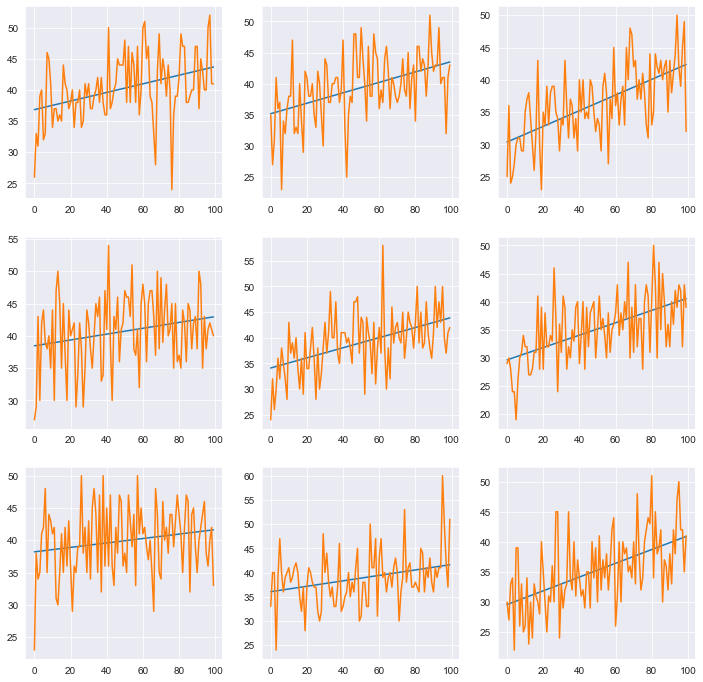

In [306]:
lr_l = [0.1, 0.3, 0.5]
exp_rate_l = [0.3,0.5,1]
combos = list(itertools.product(lr_l,exp_rate_l))
f, axes = plt.subplots(3, 3, figsize=(12, 12))

for index, combo in enumerate(combos):
    sol = BlackJackSolution(lr=combo[0],exp_rate=combo[1])
    print(f'Playing Set {index}...')
    sol.play(10000)
    
    countWindow = 100
    sumGames = np.add.reduceat(sol.gameTrack, np.arange(0, len(sol.gameTrack), countWindow))
    
    # Create regression 
    coef = np.polyfit(np.arange(len(sumGames)),sumGames,1)
    poly1d_fn = np.poly1d(coef)
    
    sns.lineplot(data=poly1d_fn(np.arange(len(sumGames))), ax=axes[math.floor(index/3),index % 3])
    sns.lineplot(data=sumGames,ax=axes[math.floor(index/3),index % 3])

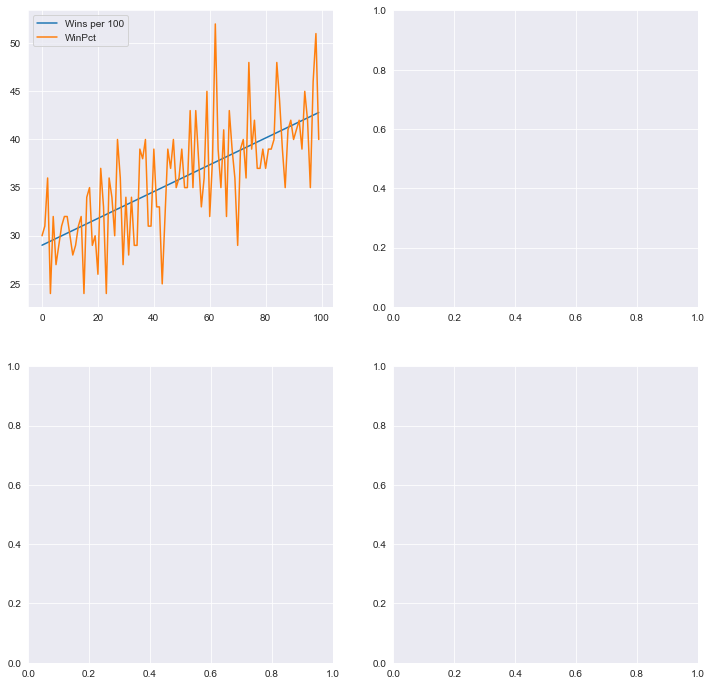

In [291]:
f, axes = plt.subplots(2, 2, figsize=(12, 12))

sns.set_style("darkgrid")
sns.lineplot(data=poly1d_fn(np.arange(len(sumGames))), label=f"Wins per {countWindow}", ax=axes[0,0])
sns.lineplot(data=sumGames,label='WinPct',ax=axes[0,0])

#plt.plot(sumGames)
#plt.plot(np.arange(len(sumGames)),poly1d_fn(np.arange(len(sumGames))),'--k')

In [307]:
sol.player_Q_Values

{(12, 1, True): {1: -0.193, 0: 0},
 (12, 1, False): {1: -0.303, 0: -0.867},
 (12, 2, True): {1: 0.694, 0: 0.875},
 (12, 2, False): {1: -0.598, 0: -0.961},
 (12, 3, True): {1: -0.149, 0: -0.5},
 (12, 3, False): {1: 0.044, 0: -0.951},
 (12, 4, True): {1: 0.253, 0: 0},
 (12, 4, False): {1: 0.387, 0: -0.918},
 (12, 5, True): {1: 0.438, 0: -0.688},
 (12, 5, False): {1: -0.933, 0: -0.916},
 (12, 6, True): {1: -0.685, 0: -0.75},
 (12, 6, False): {1: -0.932, 0: -0.405},
 (12, 7, True): {1: -0.458, 0: 0.344},
 (12, 7, False): {1: 0.252, 0: -0.591},
 (12, 8, True): {1: -0.135, 0: -0.5},
 (12, 8, False): {1: -0.637, 0: -0.98},
 (12, 9, True): {1: 0.142, 0: -0.75},
 (12, 9, False): {1: -0.844, 0: -0.989},
 (12, 10, True): {1: 0.008, 0: 0.91},
 (12, 10, False): {1: -0.459, 0: -0.997},
 (13, 1, True): {1: -0.44, 0: -0.812},
 (13, 1, False): {1: -0.677, 0: -0.871},
 (13, 2, True): {1: 0.348, 0: -0.375},
 (13, 2, False): {1: -0.506, 0: -0.975},
 (13, 3, True): {1: -0.523, 0: -0.391},
 (13, 3, False): 